Approach: DeBERTa very large model (fine tuning)

In [1]:
# model_name = "microsoft/deberta-v2-xlarge"
model_name = "microsoft/deberta-v3-base"

### Install dependencies

In [2]:
!pip install tokenizers -q
!pip install transformers -q
!pip install transformers[torch] -q
!pip install seqeval -q
!pip install evaluate -q
!pip install sentencepiece -q

In [32]:
import spacy
import numpy as np
import pandas as pd
import json
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from transformers import AutoTokenizer, BertTokenizer, DebertaTokenizerFast,  DebertaForSequenceClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification, TrainerCallback
from datasets import DatasetDict, Dataset, load_metric, load_from_disk
import traceback
from tqdm import tqdm
from evaluate import load
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW
from google.colab import drive
import warnings
import pickle
from scipy.special import softmax

In [4]:
class EmptyCacheCallback(TrainerCallback):
    def on_train_batch_end(self, args, state, control, *_) -> None:
        torch.cuda.empty_cache()

# Instantiate the EmptyCacheCallback
empty_cache_callback = EmptyCacheCallback()

In [5]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/256_Project
PATH = '/content/drive/MyDrive/256_Project'
MODEL_PATH = PATH + '/deberta-kfold'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/256_Project


### Load dataset (skip when needed)

In [ ]:
with open('data/NER_TRAIN_JUDGEMENT.json', 'r') as f:
    train_judge = json.load(f)

with open('data/NER_TRAIN_PREAMBLE.json', 'r') as f:
    train_preamble = json.load(f)

with open('data/NER_DEV_JUDGEMENT.json', 'r') as f:
    test_judge = json.load(f)

with open('data/NER_DEV_PREAMBLE.json', 'r') as f:
    test_preamble = json.load(f)

In [ ]:
len(train_judge), len(train_preamble), len(test_judge), len(test_preamble)

(9435, 1560, 949, 125)

In [ ]:
test_judge[0]

{'id': '03f3901e95ed493b866bd7807f623bc0',
 'annotations': [{'result': [{'value': {'start': 10,
      'end': 22,
      'text': 'Constitution',
      'labels': ['STATUTE']},
     'id': '25TFDATV',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels'},
    {'value': {'start': 108,
      'end': 155,
      'text': 'R.C. Cooper v. Union of India, (1970) 1 SCC 248',
      'labels': ['PRECEDENT']},
     'id': 'F706LMQM',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels'},
    {'value': {'start': 160,
      'end': 209,
      'text': 'Maneka Gandhi v. Union of India, (1978) 1 SCC 248',
      'labels': ['PRECEDENT']},
     'id': '2EURBJSZ',
     'from_name': 'label',
     'to_name': 'text',
     'type': 'labels'}]}],
 'data': {'text': "True, our Constitution has no 'due process' clause or the VIII Amendment; but, in this branch of law, after R.C. Cooper v. Union of India, (1970) 1 SCC 248 and Maneka Gandhi v. Union of India, (1978) 1 SCC 248, the conseq

In [ ]:
# test_preamble[0]

### Initializing tokenizer & Label Encoder

In [6]:
ner_labels = ['NO_TAG', 'COURT', 'PETITIONER', 'RESPONDENT', 'JUDGE', 'LAWYER', 'DATE', 'ORG', 'GPE', 'STATUTE',
              'PROVISION', 'PRECEDENT', 'CASE_NUMBER', 'WITNESS', 'OTHER_PERSON']

label_encoder = LabelEncoder()
label_encoder.fit(ner_labels)

encoded_labels = label_encoder.transform(ner_labels)
print(label_encoder.inverse_transform([6])[0])
# label_encoder.transform(['NO_TAG'])[0]

print(encoded_labels)
print(type(encoded_labels))

NO_TAG
[ 6  1  9 12  4  5  2  7  3 13 11 10  0 14  8]
<class 'numpy.ndarray'>


In [7]:
# tokenizer = DebertaTokenizer.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
# # Test Example
# # text = "Hello, World eating"
# text = "True, our Constitution has no 'due process' clause or the VIII Amendment; but, in this branch of law, after R.C. Cooper v. Union of India, (1970) 1 SCC 248 and Maneka Gandhi v. Union of India, (1978) 1 SCC 248, the consequence is the same."
# tokenized_output = tokenizer(text, truncation=True, padding=True, return_offsets_mapping=True, return_tensors="pt")
# tokens = tokenizer.convert_ids_to_tokens(tokenized_output["input_ids"][0])

# print(tokens)
# print(len(tokens))
# print(tokenized_output)
# print(tokenized_output.input_ids)
# print(type(tokenized_output))
# print(tokenized_output.word_ids())



### Data Preprocessing (skip when needed)

Start, end in dataset is 1 indexed <br/>
start - starts from 1 <br/>
end - 1 character after the word

In [ ]:
def get_token_start(start, end, offsets_mapping, word_ids):
    token_start = None
    for i, interval in enumerate(offsets_mapping):
        left, right = interval
        if left<=start<right:
            token_start = i
            break

    if token_start>0:
        if word_ids[token_start-1]==word_ids[token_start]:
            token_start -=1

    return token_start

def get_token_end(start, end, offsets_mapping, word_ids):
    token_end = None
    for i, interval in enumerate(offsets_mapping):
        left, right = interval
        if left<end<=right:
            token_end = i
            break
        if left>end:
          token_end = i-1
          break

    if token_end<len(word_ids)-1:
        if word_ids[token_end+1]==word_ids[token_end]:
            token_end +=1

    return token_end

In [ ]:
def process_individual_record(rec):

    try:
        text = rec['data']['text']
        text = text.replace("),", ") ,").replace(").", ") .").replace("],", "] ,").replace("].", "] .")
        annotations = rec['annotations'][0]['result']

        # Get the start and end positions of annotated tokens
        annotated_token_positions = [(ann['value']['start'], ann['value']['end']) for ann in annotations]

        tokenized_inputs = tokenizer(text, padding="max_length", max_length=120, truncation= True, return_offsets_mapping=True, return_tensors="pt")
#         tokenized_inputs = tokenizer(text, truncation=True, padding=True, max_length=3500, return_offsets_mapping=True, return_tensors="pt")

        input_ids = tokenized_inputs["input_ids"][0]
        offsets_mapping = tokenized_inputs["offset_mapping"][0]
        word_ids = tokenized_inputs.word_ids()

        # Initialize label_ids with NO_TAG for all tokens
        label_ids = [label_encoder.transform(['NO_TAG'])[0]] * len(input_ids)
        label_ids[0] = -100
        label_ids[-1] = -100

        # Assign labels to annotated tokens
        for start, end in annotated_token_positions:

            if start>=120 or end>=120: continue

            # Find the corresponding token positions in input_ids using offsets_mapping
            token_start = get_token_start(start, end, offsets_mapping, word_ids)
            token_end = get_token_end(start, end, offsets_mapping, word_ids)

            # Assign the label to the corresponding token(s)
            label = [ann['value']['labels'][0] for ann in annotations if ann['value']['start'] == start and ann['value']['end'] == end]
            label_id = label_encoder.transform(label)[0]
            label_ids[token_start:token_end] = [label_id] * (token_end - token_start)

        assert len(label_ids)==len(input_ids)

        row = {
            "input_ids": tokenized_inputs["input_ids"][0],
            "attention_mask": tokenized_inputs["attention_mask"][0],
            "labels": torch.tensor(label_ids)
        }

    except Exception as e:
        traceback.print_exc()
        print("\n")
        print(rec)
        print(tokenizer.convert_ids_to_tokens(input_ids))
        print(start)
        print(end)
#         tstart = int((offsets_mapping[:,0] == start-1).nonzero()[0])
#         print(tokenizer.convert_ids_to_tokens(input_ids)[tstart])
        print(offsets_mapping)

        raise SystemExit


    return row


In [ ]:
# Prepare train & val set
combined_train_data = train_judge + train_preamble
rows = []
for rec in tqdm(combined_train_data):
    row = process_individual_record(rec)
    rows.append(row)


100%|██████████| 10995/10995 [00:37<00:00, 294.08it/s]


In [ ]:
train_dic = {key: [dic[key] for dic in rows] for key in rows[0]}
train_dataset = Dataset.from_dict(train_dic)

print(train_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10995
})


In [ ]:
# train_data, val_data = train_test_split(rows, test_size=995, random_state=42)

# train_dic = {key: [dic[key] for dic in train_data] for key in train_data[0]}
# val_dic = {key: [dic[key] for dic in val_data] for key in val_data[0]}

# train_dataset = Dataset.from_dict(train_dic)
# val_dataset = Dataset.from_dict(val_dic)

# print(train_dataset)
# print(val_dataset)

In [ ]:
# Prepare test set
combined_test_data = test_judge + test_preamble
rows = []
for rec in tqdm(combined_test_data):
    row = process_individual_record(rec)
    rows.append(row)

data_dict = {key: [dic[key] for dic in rows] for key in rows[0]}
test_dataset = Dataset.from_dict(data_dict)

print(test_dataset)

100%|██████████| 1074/1074 [00:03<00:00, 345.68it/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1074
})


In [ ]:
tokenized_dataset = DatasetDict({
    "train": train_dataset,
    # "validation": val_dataset,
    "test": test_dataset
})

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10995
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1074
    })
})

In [ ]:
# del rows, data_dict, train_data, val_data, train_dic, val_dic, combined_train_data, combined_test_data, test_judge, test_preamble, train_judge, train_preamble

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'train_data' is not defined

In [ ]:
tokenized_dataset.save_to_disk(MODEL_PATH + "/dataset")

Saving the dataset (0/1 shards):   0%|          | 0/10995 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1074 [00:00<?, ? examples/s]

### Load tokenized data

In [9]:
tokenized_dataset = load_from_disk(MODEL_PATH + "/dataset")

In [10]:
# sanity check

for example in tokenized_dataset["train"]:
    assert len(example["input_ids"]) == 120
    assert len(example["attention_mask"]) == 120
    assert len(example["labels"]) == 120

In [11]:
# data_collator = DataCollatorForTokenClassification(tokenizer, padding="max_length", max_length=3500)
data_collator = DataCollatorForTokenClassification(tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

### Initialize Model

In [12]:
# check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [13]:
def get_prepared_model():
  """Get a new non-finetuned Model"""
  torch.cuda.empty_cache() # save GPU memory
  model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))
  model.to(device)
  model.train() # fine tuned entire model rather than just the head
  return model

In [14]:
metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_encoder.inverse_transform([p])[0] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_encoder.inverse_transform([l])[0] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


### Fine tuning

In [15]:
batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 10

# model = get_prepared_model()

# Training Args
training_args = TrainingArguments(
    output_dir = MODEL_PATH + '/',
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy = "epoch",
    disable_tqdm = False,
    save_strategy = "no",
    logging_steps = logging_steps,
    gradient_accumulation_steps=1,  # optimization
    fp16=True) # optimization :  enable mixed precision training

In [16]:
def get_trainer(train_data, val_data, model):
  trainer = Trainer(
      model = model,
      args = training_args,
      train_dataset = train_data,
      eval_dataset = val_data,
      data_collator = data_collator,
      tokenizer = tokenizer,
      compute_metrics = compute_metrics,
      callbacks=[empty_cache_callback]  # Register the callback
  )

  return trainer

In [17]:
# len(trainer.train_dataset[-1]['input_ids']), len(trainer.eval_dataset[100]['input_ids']), len(trainer.eval_dataset[5]['attention_mask'])

In [18]:
warnings.filterwarnings("ignore", category=UserWarning) # Suppress the Seqeval warning

In [19]:
# trainer.train()

In [20]:
# trainer.save_model(MODEL_PATH + '/trained_model')

In [21]:
# # Save the trainer's log_history
# with open(MODEL_PATH + '/trainer_log_history.pkl', 'wb') as f:
#     pickle.dump(trainer.state.log_history, f)

### Load model for inference

In [ ]:
# trained_model_path = MODEL_PATH + '/trained_model'
# model_trained = AutoModelForTokenClassification.from_pretrained(trained_model_path)
# tokenizer_trained = DebertaTokenizerFast.from_pretrained(trained_model_path)

In [ ]:
# trainer = Trainer(
#     model = model_trained,
#     args = training_args, #run training_args block
#     train_dataset = tokenized_dataset["train"], #run 'load tokenized data' block
#     eval_dataset = tokenized_dataset["validation"], #run 'load tokenized data' block
#     data_collator = data_collator, #run 'load tokenized data' block
#     tokenizer = tokenizer_trained,
#     compute_metrics = compute_metrics,
#     callbacks=[empty_cache_callback]  # Register the callback
# )

In [ ]:
# Load the trainer's log_history
with open(MODEL_PATH + '/trainer_log_history.pkl', 'rb') as f:
    trainer_log_history = pickle.load(f)

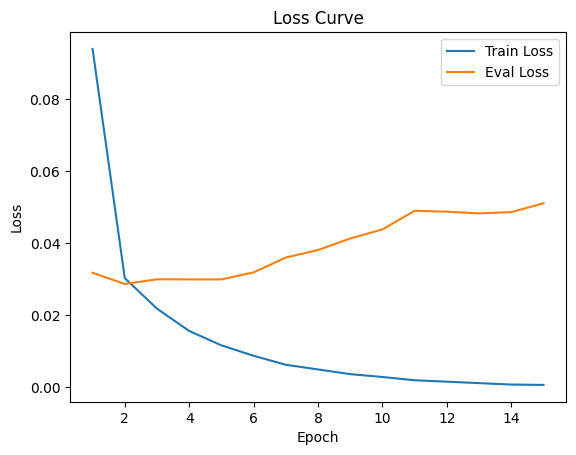

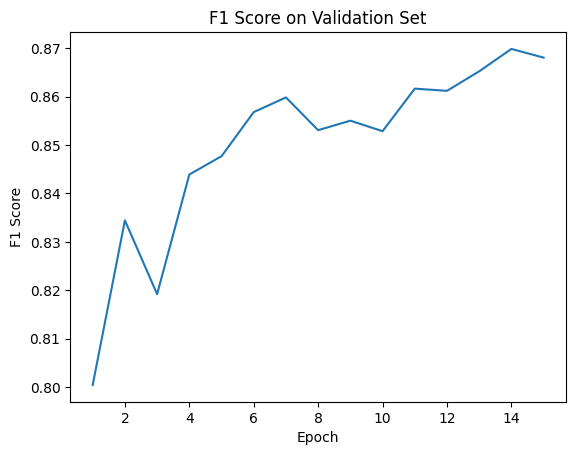

In [ ]:
train_losses = []
eval_losses = []
f1_values = []
# acc_values = []
epoch_list = list(range(1, epochs+1))

for entry in trainer_log_history:
  # print(entry)
  if 'loss' in entry:
      train_losses.append(entry['loss'])
  if 'eval_loss' in entry:
      eval_losses.append(entry['eval_loss'])
  if 'eval_f1' in entry:
      f1_values.append(entry['eval_f1'])

# Plot loss curve
plt.plot(epoch_list, train_losses, label='Train Loss')
plt.plot(epoch_list, eval_losses, label='Eval Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot F1 score
plt.plot(epoch_list, f1_values, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score on Validation Set')
plt.show()

#### Evaluate on Val set

In [ ]:
trainer.evaluate()

{'eval_loss': 0.05109316110610962,
 'eval_precision': 0.8596252129471891,
 'eval_recall': 0.8766504517025713,
 'eval_f1': 0.8680543609151901,
 'eval_accuracy': 0.9922493825057491,
 'eval_runtime': 22.1184,
 'eval_samples_per_second': 44.985,
 'eval_steps_per_second': 2.848,
 'epoch': 15.0}

#### Evaluate on Test set

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_encoder.inverse_transform([p])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = [
    [label_encoder.inverse_transform([l])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

In [ ]:
results = metric.compute(predictions=true_predictions, references=true_labels)

results_dict = {
    "Label": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "Number": []
}

for label, metrics in results.items():
    if label != "overall_precision" and label != "overall_recall" and label != "overall_f1" and label != "overall_accuracy":
        results_dict["Label"].append(label)
        results_dict["Precision"].append(metrics["precision"])
        results_dict["Recall"].append(metrics["recall"])
        results_dict["F1-score"].append(metrics["f1"])
        results_dict["Number"].append(metrics["number"])

results_df = pd.DataFrame(results_dict)
print(results_df)

print(f"\nOverall Precision :{results['overall_precision']}\nOverall Recall: {results['overall_recall']}\nOverall F1 : {results['overall_f1']}\nOverall Accuracy: {results['overall_accuracy']}\n")


         Label  Precision    Recall  F1-score  Number
0   ASE_NUMBER   0.647059  0.785714  0.709677      70
1          ATE   0.931034  0.939130  0.935065     115
2    ESPONDENT   0.500000  0.571429  0.533333       7
3    ETITIONER   0.550000  0.687500  0.611111      16
4       ITNESS   0.833333  0.975610  0.898876      41
5         OURT   0.884422  0.936170  0.909561     188
6        O_TAG   0.855010  0.879584  0.867123    2018
7           PE   0.580000  0.644444  0.610526      45
8     RECEDENT   0.591398  0.753425  0.662651      73
9     ROVISION   0.851351  0.906475  0.878049     139
10      TATUTE   0.878049  0.888889  0.883436     162
11        UDGE   0.629630  0.894737  0.739130      19

Overall Precision :0.8371786420566908
Overall Recall: 0.8779813342550985
Overall F1 : 0.8570946515943986
Overall Accuracy: 0.9911624530505319



### K FOLD

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

X_train = tokenized_dataset['train']['input_ids']  # Replace 'input_ids' with the appropriate feature name

dataset_dict = tokenized_dataset['train']
fold = 0
for train_index, test_index in kf.split(X_train):
    print("loop")
    torch.cuda.empty_cache()
    # Split train and validation based on the train_index
    train_split = {key: np.array(dataset_dict[key])[train_index] for key in dataset_dict.features}
    validation_split = {key: np.array(dataset_dict[key])[test_index] for key in dataset_dict.features}

    train_dataset = Dataset.from_dict(train_split)
    val_dataset = Dataset.from_dict(validation_split)

    model = get_prepared_model()
    trainer = get_trainer(train_dataset, val_dataset, model)
    print("train")
    trainer.train()
    m_path = MODEL_PATH + "/model_{}".format(fold)
    trainer.save_model(m_path)

    print("predict")
    # Test set prediction
    test_pred, labels, _ = trainer.predict(tokenized_dataset["test"])
    fname = MODEL_PATH + "/fold_{}".format(fold)
    np.save(fname, np.array(test_pred))
    fold += 1



loop


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

train


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.031541,0.750297,0.808049,0.778102,0.989445
2,0.085800,0.029384,0.814780,0.827531,0.821106,0.990616
3,0.028600,0.028561,0.819389,0.847653,0.833281,0.991641
4,0.017900,0.030643,0.821934,0.871287,0.845891,0.991849
5,0.012700,0.030082,0.817153,0.876397,0.845739,0.991656
6,0.009100,0.032197,0.840553,0.873842,0.856874,0.991841
7,0.006000,0.032975,0.850170,0.878952,0.864322,0.991741
8,0.004200,0.035622,0.848140,0.881188,0.864348,0.992327
9,0.002500,0.038157,0.849138,0.880869,0.864712,0.992373
10,0.001900,0.038971,0.849109,0.882466,0.865466,0.992427


predict


loop


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

train


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.038532,0.716250,0.802279,0.756827,0.986757
2,0.082500,0.027879,0.783768,0.850631,0.815832,0.990300


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.038532,0.716250,0.802279,0.756827,0.986757
2,0.082500,0.027879,0.783768,0.850631,0.815832,0.990300
3,0.029200,0.025099,0.811963,0.873730,0.841715,0.991857
4,0.020100,0.027236,0.827496,0.873114,0.849693,0.991949
5,0.013400,0.025955,0.853798,0.875885,0.864701,0.992881
6,0.010500,0.031132,0.841630,0.890360,0.865310,0.992542
7,0.006100,0.026723,0.865627,0.888820,0.877070,0.993112
8,0.004500,0.029060,0.867617,0.900216,0.883615,0.993891
9,0.002900,0.030915,0.859888,0.895904,0.877526,0.993513
10,0.002100,0.030861,0.862559,0.896828,0.879360,0.993860


predict


loop


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

train


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.036561,0.763714,0.801499,0.782151,0.988074
2,0.081100,0.031919,0.791841,0.849775,0.819786,0.990031
3,0.027800,0.030792,0.808340,0.877661,0.841576,0.990015
4,0.019100,0.034153,0.831294,0.855472,0.843210,0.990894
5,0.012900,0.032970,0.843387,0.871964,0.857438,0.991148
6,0.008500,0.041113,0.851588,0.860270,0.855907,0.990277
7,0.006400,0.038136,0.835425,0.878261,0.856308,0.991233
8,0.003900,0.039474,0.843103,0.879760,0.861042,0.991633
9,0.002800,0.041447,0.851540,0.878861,0.864985,0.991479
10,0.002000,0.042798,0.845757,0.884558,0.864722,0.991787


predict


loop


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

train


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.037271,0.724068,0.791285,0.756186,0.988089
2,0.081800,0.034131,0.705882,0.829807,0.762845,0.987712
3,0.028500,0.029923,0.779310,0.856331,0.816007,0.990424
4,0.019900,0.030145,0.813711,0.862015,0.837167,0.991718
5,0.013300,0.032605,0.807074,0.871803,0.838191,0.991125
6,0.010300,0.031697,0.820851,0.865172,0.842429,0.991880
7,0.006800,0.036549,0.815511,0.876539,0.844925,0.990724
8,0.004800,0.039557,0.804821,0.874961,0.838427,0.990578
9,0.003200,0.040104,0.821019,0.880644,0.849787,0.991564
10,0.002300,0.037376,0.828622,0.879381,0.853248,0.991965


predict


loop


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

train


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.036949,0.705706,0.806552,0.752766,0.986703
2,0.080200,0.042740,0.697819,0.838690,0.761797,0.985763
3,0.027500,0.039315,0.805895,0.801872,0.803879,0.987681
4,0.019000,0.032946,0.815259,0.870203,0.841835,0.990616
5,0.013400,0.036291,0.824828,0.862402,0.843197,0.990316
6,0.009300,0.038816,0.819118,0.868955,0.843301,0.990462


#### Second run

In [24]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
X_train = tokenized_dataset['train']['input_ids']  # Replace 'input_ids' with the appropriate feature name

dataset_dict = tokenized_dataset['train']
fold = 0
for train_index, test_index in kf.split(X_train):
    if fold<4:
      fold+=1
      continue

    print(f"Fold : {fold}")

    torch.cuda.empty_cache()
    # Split train and validation based on the train_index
    train_split = {key: np.array(dataset_dict[key])[train_index] for key in dataset_dict.features}
    validation_split = {key: np.array(dataset_dict[key])[test_index] for key in dataset_dict.features}

    train_dataset = Dataset.from_dict(train_split)
    val_dataset = Dataset.from_dict(validation_split)

    model = get_prepared_model()
    trainer = get_trainer(train_dataset, val_dataset, model)

    trainer.train()
    m_path = MODEL_PATH + "/model_{}".format(fold)
    trainer.save_model(m_path)


    # Test set prediction
    test_pred, labels, _ = trainer.predict(tokenized_dataset["test"])
    fname = MODEL_PATH + "/fold_{}".format(fold)
    np.save(fname, np.array(test_pred))
    fold += 1


Fold : 4


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.038151,0.720167,0.807800,0.761471,0.986055
2,0.087900,0.039831,0.725209,0.837441,0.777295,0.986980
3,0.026400,0.042427,0.808805,0.785335,0.796897,0.986841
4,0.018600,0.033438,0.820636,0.853666,0.836825,0.990347
5,0.013000,0.037131,0.806982,0.872699,0.838555,0.990077
6,0.008900,0.035165,0.827321,0.873011,0.849552,0.990416
7,0.006500,0.040048,0.807981,0.871763,0.838661,0.989892
8,0.004200,0.039748,0.816049,0.878939,0.846327,0.990262
9,0.003000,0.042201,0.832937,0.874259,0.853098,0.990994
10,0.002100,0.043782,0.831598,0.872075,0.851355,0.991063


Fold : 5


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.044833,0.657631,0.821037,0.730305,0.984508
2,0.081800,0.030705,0.803152,0.854573,0.828065,0.989736
3,0.029600,0.028778,0.823272,0.860671,0.841556,0.990616
4,0.019600,0.030601,0.824715,0.860671,0.842309,0.991379
5,0.013600,0.032433,0.849534,0.860671,0.855066,0.991194
6,0.009900,0.035705,0.817537,0.878354,0.846855,0.991209
7,0.006400,0.033652,0.863826,0.883841,0.873719,0.992212
8,0.004700,0.037385,0.853262,0.881098,0.866957,0.991780
9,0.003200,0.040876,0.841439,0.891463,0.865729,0.991518
10,0.002300,0.040887,0.853552,0.890244,0.871512,0.992073


Fold : 6


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.033059,0.764230,0.791499,0.777625,0.988071
2,0.081900,0.026244,0.786484,0.837729,0.811298,0.990747
3,0.028100,0.029503,0.780188,0.847968,0.812667,0.989721
4,0.019400,0.031004,0.827248,0.864722,0.845570,0.991302
5,0.013600,0.030968,0.825771,0.880856,0.852425,0.992019
6,0.008600,0.033689,0.851976,0.869687,0.860740,0.992096
7,0.006400,0.032748,0.841610,0.888613,0.864473,0.991950
8,0.004500,0.035918,0.832215,0.884890,0.857744,0.992374
9,0.002900,0.036640,0.843907,0.887372,0.865094,0.992713
10,0.002200,0.037533,0.846381,0.888923,0.867131,0.992775


Fold : 7


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.047385,0.648025,0.791850,0.712754,0.983868
2,0.080800,0.030791,0.810974,0.843260,0.826802,0.990454
3,0.027100,0.033596,0.785450,0.866458,0.823968,0.989667
4,0.019000,0.032669,0.791773,0.874922,0.831273,0.990353
5,0.012900,0.036302,0.783784,0.872727,0.825868,0.989906
6,0.008900,0.039389,0.782804,0.873354,0.825604,0.990338
7,0.006600,0.036900,0.816458,0.877116,0.845700,0.991464
8,0.004200,0.040091,0.824237,0.880564,0.851470,0.991649
9,0.002700,0.042120,0.830133,0.880878,0.854753,0.991772
10,0.002000,0.042184,0.831461,0.881505,0.855752,0.991965


Fold : 8


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.046851,0.650409,0.786354,0.711950,0.982573
2,0.082300,0.036436,0.750983,0.825872,0.786649,0.987732
3,0.027900,0.034099,0.775416,0.833591,0.803452,0.988433
4,0.018900,0.037496,0.787955,0.868478,0.826259,0.989150
5,0.013300,0.041497,0.812408,0.849027,0.830314,0.990014
6,0.009100,0.044609,0.807648,0.860759,0.833358,0.990091
7,0.006000,0.048793,0.823249,0.852732,0.837731,0.989844
8,0.004100,0.048096,0.825339,0.844705,0.834910,0.990685
9,0.002700,0.049389,0.832050,0.867243,0.849282,0.990924
10,0.001800,0.050870,0.825360,0.868169,0.846223,0.991055


Fold : 9


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a Be

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.036730,0.695010,0.803157,0.745180,0.986367
2,0.081600,0.031859,0.768670,0.815722,0.791497,0.989521
3,0.028100,0.031214,0.777268,0.872423,0.822101,0.989883
4,0.019500,0.030135,0.795322,0.876289,0.833844,0.990731
5,0.012700,0.028664,0.831641,0.870490,0.850622,0.992297
6,0.009300,0.033364,0.825023,0.868879,0.846383,0.991657
7,0.006500,0.033574,0.838530,0.875000,0.856377,0.992219
8,0.004500,0.040058,0.833032,0.890464,0.860791,0.991834
9,0.002900,0.039068,0.852602,0.881443,0.866783,0.992443
10,0.002100,0.041294,0.848457,0.885631,0.866646,0.992304


### Ensembling

In [36]:
num_folds = 10
model_logits = []

# Load the model logits for each fold
for fold in range(num_folds):
    fname = MODEL_PATH + "/fold_{}".format(fold)
    fold_logits = np.load(fname + ".npy")
    model_logits.append(fold_logits)


softmaxed_pred = [softmax(f, axis = -1) for f in model_logits] # confidence for each prediction
avg_pred = sum(softmaxed_pred)/len(softmaxed_pred) # mean confidence
test_predictions = np.argmax(avg_pred, -1)

In [37]:
len(model_logits), fold_logits.shape, len(softmaxed_pred), len(softmaxed_pred[0]), test_predictions.shape, labels.shape

(10, (1074, 120, 15), 10, 1074, (1074, 120), (1074, 120))

In [38]:
# Remove ignored index (special tokens)
true_predictions = [
    [label_encoder.inverse_transform([p])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(test_predictions, labels)
]

true_labels = [
    [label_encoder.inverse_transform([l])[0] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(test_predictions, labels)
]

In [39]:
results = metric.compute(predictions=true_predictions, references=true_labels)

results_dict = {
    "Label": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "Number": []
}

for label, metrics in results.items():
    if label != "overall_precision" and label != "overall_recall" and label != "overall_f1" and label != "overall_accuracy":
        results_dict["Label"].append(label)
        results_dict["Precision"].append(metrics["precision"])
        results_dict["Recall"].append(metrics["recall"])
        results_dict["F1-score"].append(metrics["f1"])
        results_dict["Number"].append(metrics["number"])

results_df = pd.DataFrame(results_dict)
print(results_df)

print(f"\nOverall Precision :{results['overall_precision']}\nOverall Recall: {results['overall_recall']}\nOverall F1 : {results['overall_f1']}\nOverall Accuracy: {results['overall_accuracy']}\n")

         Label  Precision    Recall  F1-score  Number
0   ASE_NUMBER   0.731707  0.857143  0.789474      70
1          ATE   0.923729  0.947826  0.935622     115
2    ESPONDENT   0.571429  0.571429  0.571429       7
3    ETITIONER   0.600000  0.750000  0.666667      16
4       ITNESS   0.866667  0.951220  0.906977      41
5         OURT   0.906736  0.930851  0.918635     188
6        O_TAG   0.869817  0.893954  0.881720    2018
7           PE   0.632653  0.688889  0.659574      45
8     RECEDENT   0.652632  0.849315  0.738095      73
9     ROVISION   0.919708  0.906475  0.913043     139
10      TATUTE   0.894444  0.993827  0.941520     162
11        UDGE   0.607143  0.894737  0.723404      19

Overall Precision :0.8586525759577279
Overall Recall: 0.8987210508123056
Overall F1 : 0.8782300287113664
Overall Accuracy: 0.9925985544298204

